# Machine Learning in Python - Project 1

Due Friday, March 18th by 5 pm.

by Dickon Fell, Austin Grehan, Andy Grant, Hari Madhukumar

## 0. Setup

In [1]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# Miscelaneous packages
from collections import Counter

#!pip install feature_engine

In [2]:
# Load data
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/project')

Mounted at /content/drive


In [3]:
d = pd.read_csv('the_office.csv')

## 1. Introduction

We will be using data about the American TV show The Office.The dataset includes the following columns:

* `season` - Season number of the episode

* `episode` - Episode number within a season

* `episode_name` - Episode name

* `director` - Episode director(s), names are separated by `;`

* `writer` - Episode writer(s), names are separated by `;`

* `imdb_rating` - Episode rating on IMDB

* `total_votes` - Number of ratings for episode on IMDB

* `air_date` - Original air date of episode

* `n_lines` - Number of spoken lines in episode

* `n_directions` - Number of lines containing a stage direction

* `n_words` - Number of dialog words in episide

* `n_speak_char` - Number of different characters with spoken lines in episode

* `main_chars` - Main characters appearing in episode (main characters were determined to be characters appearing in more than 1/2 of the episodes)

In [4]:
d.head() # look at top of the data

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
4,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...


These data were derived from the data available in the [`schrutepy`](https://pypi.org/project/schrutepy/) package. The package provides a data frame containing the entire text transcripts from all episodes of the show.

We play the role of a Data Scientist contractor who has been hired by NBC Universal to advise on the creation of a special reunion episode of The Office. Our employers are particularly interested in understanding what made some episodes more popular than others. We seek to use these data to build a predictive model that captures the underlying relationships between these features and the audience ratings, and then use the insights gained from this model to advise what NBC Universal should do to produce the highest rated reunion episode possible.

In other words, we will be developing an *understandable* *validated* model for The Office's `imdb_rating` as the outcome of interest, using features derived from the data provided and any additional sources. It is important that this model be accurate **and** reliable and any conclusions we draw well supported and sound. We explicitly do not want a blackbox model - it should be possible to explain and justify our modeling choices and our model's predictions.

We will select which of the provided features we would like to use based on our exploration of the data, and we will transform and manipulate these as necessary to generate additional features. Then we will fit a number of models to our data and evaluate their performance, then compare to select the best one for our purposes. Finally we will discuss the results of our modelling in context of the problem - creating a special reunion episode.



## 2. Exploratory Data Analysis and Feature Engineering

We will start by taking a slightly more in depth look at the data and features, so we can learn about the relationships between them and our output.

In [5]:
d.info() # data information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        186 non-null    int64  
 1   episode       186 non-null    int64  
 2   episode_name  186 non-null    object 
 3   director      186 non-null    object 
 4   writer        186 non-null    object 
 5   imdb_rating   186 non-null    float64
 6   total_votes   186 non-null    int64  
 7   air_date      186 non-null    object 
 8   n_lines       186 non-null    int64  
 9   n_directions  186 non-null    int64  
 10  n_words       186 non-null    int64  
 11  n_speak_char  186 non-null    int64  
 12  main_chars    186 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 19.0+ KB


As you can see, there are no null entries to worry about. However there are a variety of data types so we will need to work around this.

Looking at the top of the data, we can see that some episodes have multiple writer/director/main_chars. We would like to get a list of all of these individuals so we can investigate each of them in more detail. We wrote the `unique_names` function below to seperate out the individuals from these columns.

In [6]:
def unique_names(column, dataframe):
  """
  Given a column containing strings with groups of names, separated by ";",
  returns the unique names found in that column.

  Inputs:
  column - column name (string)

  Outputs:
  people - strings of unique names found (numpy array)
  """

  # get rows of the given column containing groups of names
  entries = sorted(dataframe[column].unique())

  # split up into individuals
  people = []
  for entry in entries:
    people += entry.split(";")

  people = np.array(people) # convert list to np.array

  return np.unique(people) # get unique elements of array

In [7]:
unique_names("director",d) # names of all the directors

array(['Alex Hardcastle', 'Amy Heckerling', 'Asaad Kelada', 'B.J. Novak',
       'Brent Forrester', 'Brian Baumgartner', 'Bryan Cranston',
       'Bryan Gordon', 'Charles McDougal', 'Charles McDougall',
       'Charlie Grandy', 'Claire Scanlon', 'Claire Scanlong',
       'Craig Zisk', 'Daniel Chun', 'Danny Leiner', 'David Rogers',
       'Dean Holland', 'Dennie Gordon', 'Ed Helms', 'Eric Appel',
       'Gene Stupnitsky', 'Greg Daneils', 'Greg Daniels', 'Harold Ramis',
       'J.J. Abrams', 'Jason Reitman', 'Jeffrey Blitz',
       'Jennifer Celotta', 'Jesse Peretz', 'John Krasinski', 'John Scott',
       'Jon Favreau', 'Joss Whedon', 'Julian Farino',
       'Kelly Cantley-Kashima', 'Ken Kwapis', 'Ken Whittingham',
       'Ken Wittingham', 'Lee Eisenberg', 'Lee Kirk', 'Marc Webb',
       'Matt Sohn', 'Michael Spiller', 'Miguel Arteta', 'Mindy Kaling',
       'Paul Feig', 'Paul Lieberstein', 'Paul Lieerstein', 'Rainn Wilson',
       'Randall Einhorn', 'Reginald Hudlin', 'Rodman Flender',


It can be seen above that there are a few directors credited whose names are suspiciously similar, for example 'Greg Daniels' and 'Greg Daneils'. After some research it is clear that these mistakes are typos, so we correct the mistakes accordingly.

In [8]:
# replacing erroneous names
d.director.replace('Ken Wittingham','Ken Whittingham',inplace=True)
d.director.replace('Greg Daneils','Greg Daniels',inplace=True)
d.director.replace('Charles McDougal','Charles McDougall',inplace=True)
d.director.replace('Claire Scanlong','Claire Scanlon',inplace=True)
d.director.replace('Paul Lieerstein','Paul Lieberstein',inplace=True)

Next we wanted to see how much different writers/directors/characters affected IMDb scores. To do this we plotted average IMDb scores for each individual, across all the episodes which credit them. 

The `get_initials` function is included to improve the aesthetics of the plots, and the `plot_avg_imdb_score` does exactly what we have just described in the paragraph above.

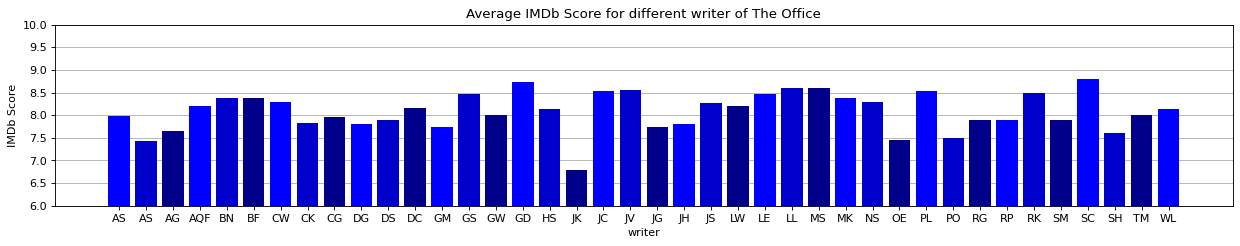

In [9]:
# https://stackoverflow.com/questions/41005700/function-that-returns-capitalized-initials-of-name
def get_initials(fullname):
  """
  Retrieves the initials from a capitalised name string.
  """
  xs = (fullname)
  name_list = xs.split()

  initials = ""

  for name in name_list:  # go through each name
    initials += name[0].upper()  # append the initial

  return initials

def plot_avg_imdb_score(column, use_initials=True):
  """
  Given a column of the data frame containing strings with groups of names, separated by ";",
  produces a bar plot of the average imdb score of all episodes relating to each of the names in that column.

  Inputs:
  column - column name (string)
  use_initials - specify whether x-axis ticks should be given as initials (boolean)
  """
  names = unique_names(column,d) # get unique names in column
  avg_imdb_scores = [d[d[column].str.contains(name)]["imdb_rating"].mean() for name in names] # average imdb score over all episodes of each person

  if use_initials:
    ticks = [get_initials(name) for name in names] # list of people's initials
  else:
    ticks = names

  fig, ax = plt.subplots(figsize=(19,3)) # large plot otherwise x-axis initials get squished
  plt.ylim(6,10)
  c = ['blue', 'mediumblue', 'darkblue']
  ax.bar(x=range(len(names)), height=avg_imdb_scores, tick_label=ticks, color=c) # plot average scores
  ax.yaxis.grid() # add horizontal gridlines
  ax.set_axisbelow(True) # gridlines behind bars
  ax.set_xlabel(column)
  ax.set_ylabel("IMDb Score")
  ax.set_title(f"Average IMDb Score for different {column} of The Office")
  plt.show()

# look at the average imdb scores for each writer, director and main character.
plot_avg_imdb_score("writer")

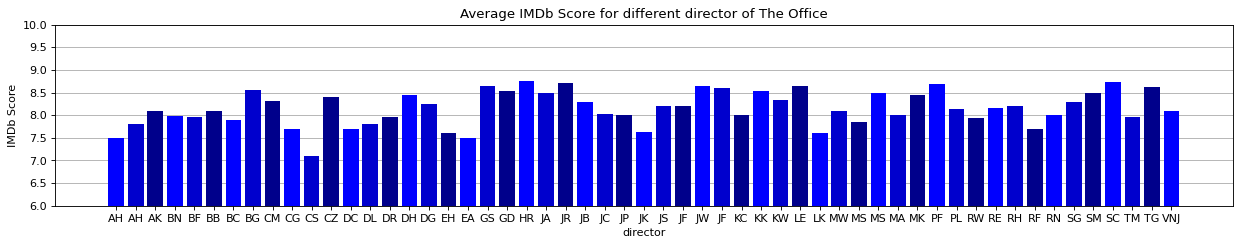

In [10]:
plot_avg_imdb_score("director")

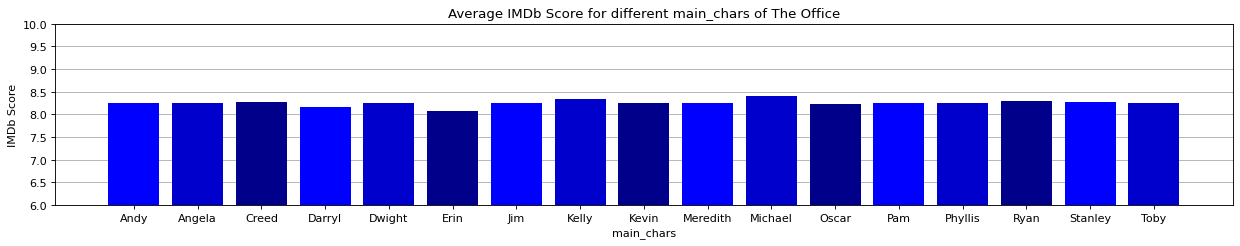

In [11]:
plot_avg_imdb_score("main_chars", use_initials=False)

As you can see, there is quite a bit of variation in the average IMDb score for each writer and director. However the variation amongst main characters is small - between 8 and 8.5 for each of them. This might be because most episodes feature most characters. However this is shown to be false below where we plotted the number of episodes that each character appears in, and found that there are large differences in the number for each character.

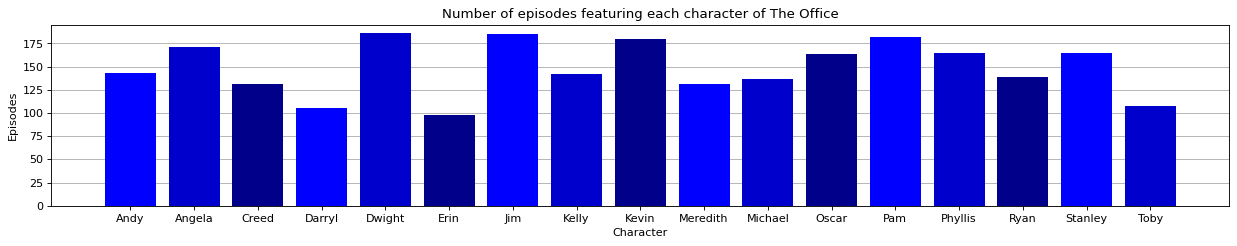

In [12]:
# plotting number of episodes that each character appears in
names = unique_names('main_chars',d)
n_episodes = [len(d[d['main_chars'].str.contains(name)]) for name in names] # number of episodes featuring each character

fig, ax = plt.subplots(figsize=(19,3)) # large plot otherwise x-axis initials get squished
c = ['blue', 'mediumblue', 'darkblue']
ax.bar(x=range(len(names)), height=n_episodes, tick_label=names, color=c) # plot episodes
ax.yaxis.grid() # add horizontal gridlines
ax.set_axisbelow(True) # gridlines behind bars
ax.set_xlabel('Character')
ax.set_ylabel("Episodes")
ax.set_title("Number of episodes featuring each character of The Office")
plt.show()

avg_imdb_scores = [d[d['main_chars'].str.contains(name)]["imdb_rating"].mean() for name in names] # average imdb score over all episodes of each character

Next we looked at the correlation matrix of the data frame, to find any highly correlated features.

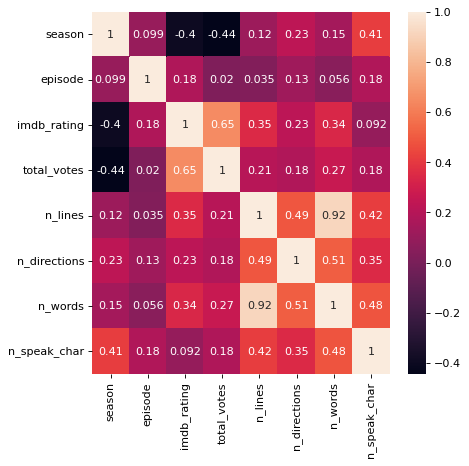

In [13]:
correlation = d.corr()
plt.figure(figsize=(6,6))
sns.color_palette("crest", as_cmap=True)
sns.heatmap(correlation, annot=True)
plt.show()

Indeed, there are some highly correlated features here. `n_words` and `n_lines` are - perhaps unsurprisingly - highly correlated. We have explored this correlation in more detail below. We can also see that `total_votes` and `imdb_score` are highly correlated.

Pearson's correlation coefficient:  0.9159588565722423 



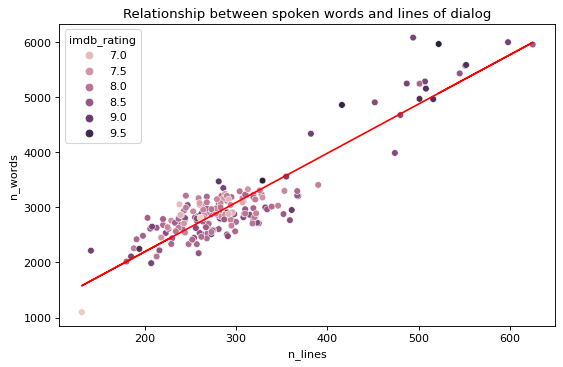

In [14]:
sns.scatterplot(x="n_lines", y="n_words",hue='imdb_rating', data=d).set(title='Relationship between spoken words and lines of dialog')
# Fitting a line to emphasise the close linear relationship.
m, b = np.polyfit(d.n_lines, d.n_words, 1)
plt.plot(d.n_lines,m*d.n_lines + b,color="red")

print("Pearson's correlation coefficient: ",d.n_lines.corr(d.n_words), "\n")

The above graph displays the close relationship between `n_lines` and `n_words`.  There are a few outliers in the data. This is to be expected since most spoken words will also be classed as dialog and hence they are essentially different measures of the same thing. There could be discrepency between the two features when episodes contain a lot of short lines of dialog, or a lot of spoken words that are not classed as dialog. However this discrepency is rarely seen since there are few anomolies in the above scatter plot.

So to avoid adding unnecesary complexity to our model we will discard one of these features. Looking at the plots of both of these features with `imdb_rating` above, it can be seen that `n_words` has a lot of points clustered close together and hence does not give us as much information with which to base our models on. `n_lines` shows a better spread and hence will be kept over `n_words`.

Now to take a look at the quantative features and the shape of their relationship with imdb_rating. These pair plots show that there is clearly some kind of relationship between `n_lines` and `imdb_rating` as well as `n_directions` and `imdb_rating`. The relationship seems to be linear, and this drove our decision not to use any polynomial features or regression trees in the modelling stage. 
Additionally, it is hard to see any kind of obvious relationship between `n_speak_char` and `imdb_rating`. This is in agreement with the correlation score of 0.092.

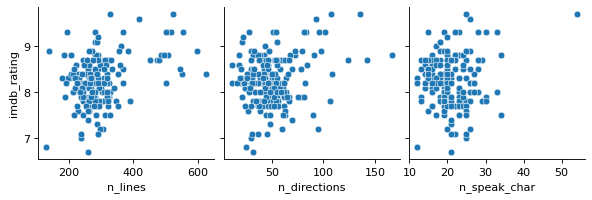

In [15]:
sns.pairplot(data=d,x_vars=['n_lines','n_directions','n_speak_char'],y_vars=['imdb_rating'])
plt.show()

We also investigated the `air_date` feature, to see if the time of year had any effect on `imdb_rating`. To do this, we plotted the scores of episodes over the course of each year, overlaying the average episode score for that year onto the graphs.

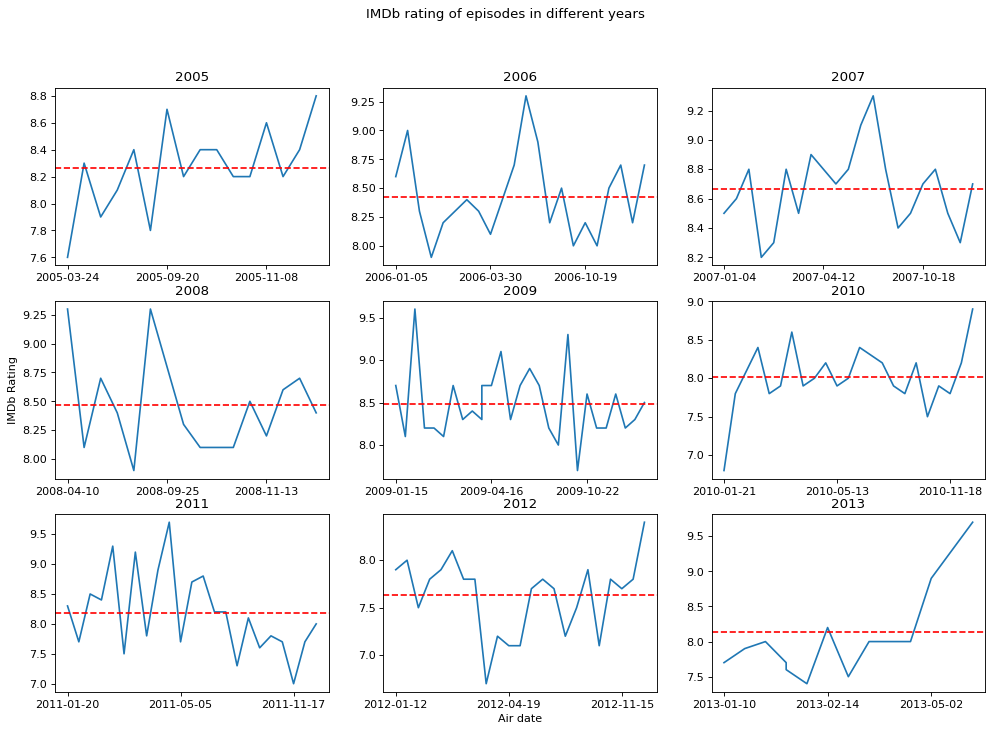

In [16]:
import matplotlib.ticker as ticker

# plotting imdb rating of episodes in each year
fig, ax = plt.subplots(3,3, figsize=(15,10))
ax[1,0].set_ylabel("IMDb Rating")
ax[2,1].set_xlabel("Air date")

for i in range(9):
  d_year = d[d['air_date'].str.contains(str(2005+i))] # data for that year
  ax[i // 3,i % 3].plot(d_year["air_date"], d_year["imdb_rating"]) # plot year data
  ax[i // 3,i % 3].axhline(y=d_year["imdb_rating"].mean(), color='r', linestyle='--') # average imdb rating over the year
  ax[i // 3,i % 3].set_title(2005+i)
  ax[i // 3,i % 3].xaxis.set_major_locator(ticker.MaxNLocator(3))

fig.suptitle('IMDb rating of episodes in different years')
plt.show()

In the resulting graphs above, there does not appear to be any discernible pattern in the data. This contributed towards our decision to ignore this feature in the final model.

Now we move on to feature engineering. To begin with we will remove any features of that data that we deem irrelevant to the output we are trying to predict - IMDb rating. We would like to remove any irrelevant features as this will help simplify our final model, which will make the output more interpretable and reduce the cost of the modelling stage. There are a few features that we can remove which we have explored:

`season` - We want to determine what makes a succesful (stand-alone) episode rather than what makes a good season hence it'll be removed.

`episode` - An episode's placing within a season is not significant since the aim is to produce a stand-alone episode. Hence this feature will be removed.

`episode_name` - Unlikely to have any effect on the viewer rating and will be removed.

`total_votes` - The aim is to model the audience rating as opposed to the number of votes or number of views.

`n_words` - This feature contains the number of spoken words in an episode. This feature is highly correlated with the n_lines feature and hence it will be removed (as illustrated and explained above).

`air_date` - Even if we do find that episodes on certain dates were more highly rated than others, we cannot go back in time to air a new episode on that date! So this feature is removed.

In [ ]:
dropped = d[['season','episode','episode_name','total_votes', 'air_date', 'n_words']]
d.drop(['season','episode','episode_name','total_votes', 'air_date', 'n_words'],axis=1,inplace=True)

Another process we will be using is one-hot encoding for categorical variables.

As mentioned above, there are a number of data types in the data frame. In particular, we have strings containing the names of various people in the `writer`, `director` and `main_chars` columns. We would like to use these features in our analysis however, so we will need to convert them to numerical variables. This is achieved through the use of one-hot encoding. This is performed in the cell below, after we reduce some of the categorical variables.

Using the `Counter` object from the `collections` library, we can determine the writers and directors who have less than 4 credits across the episodes. These people are considered 'guest' contributors, which allows us to reduce the number of features required. This also makes sense from an intuitive perspective; a writer or director with limited experience on the show would not be a good choice for the reunion episode, regardless of the quality of their contributions.

The writers Halstead Sullivan and Warrne Lieberstein only have writing credits together, resulting in their OHE columns being linearly dependent,
(they will be identical). This is the same for Lee Eisenberg and Gene Stupnitsky. This rank deficiency causes the coefficients of the linear regression to blow up after the standardization is performed. 

The rank deficiency was assumed after some basic modelling provided results many orders of magnitude above what was expected. A quick test was performed using `np.linalg.matrix_rank()` which confirmed our suspicions.

In [ ]:
# Reducing categorical variables to only show categories with 4 or more credits in the data.
# Anything less will be grouped in a guest column

# Counting the instances of each writer/director/main character in the data set
for column in ['writer','director','main_chars']:
    reduced_column = [sorted(np.unique(np.array(names))) for names in d[column].str.split(';')]
    c_column = Counter()
    for xs in reduced_column:
        for x in xs:
              c_column[x] += 1

    # If a writer or director does not have more than 3 credits, they will be considered a guest contributor,
    # reducing the features in our model.
    unique = unique_names(column,d)
    for i in range(len(unique)):
        if c_column[unique[i]] < 4:
            unique[i] = 'Guest'
    unique = set(unique)

    # Editing names to reflect guest status
    for i in range(len(reduced_column)):
        for j in range(len(reduced_column[i])):
            if reduced_column[i][j] not in unique:
                reduced_column[i][j]='Guest'
    
    # Rejoining to replicate original format
        reduced_column[i] = ';'.join(reduced_column[i])

    # One-hot encoding the adjusted categorical variables
    d[column] = reduced_column
    A = d[column].str.get_dummies(sep=';').add_prefix(column + '_')

    # Concatenating OHE columnns to dataframe
    d = pd.concat([d,A],axis=1)

# Remove redundant features and linear dependencies
dropped[['writer','main_chars','director','writer_Halsted Sullivan','writer_Lee Eisenberg','main_chars_Dwight','director_Guest','writer_Guest']] = d[['writer','main_chars','director','writer_Halsted Sullivan','writer_Lee Eisenberg','main_chars_Dwight','director_Guest','writer_Guest']]
d.drop(['writer','main_chars','director','writer_Halsted Sullivan','writer_Lee Eisenberg','main_chars_Dwight','director_Guest','writer_Guest'],axis=1,inplace=True) #,'director_Guest','writer_Guest'
d.rename(columns={'writer_Warren Lieberstein': 'writer_Warren Lieberstein; Halsted Sullivan', 'writer_Gene Stupnitsky': 'writer_Gene Stupnitsky; Lee Eisenberg'},inplace=True)

# We shuffle the data so that our k-fold split does not remove whole seasons.
d = d.sample(frac=1).reset_index(drop=True) 

# Separate the response (y) from the features (X).
y = d['imdb_rating']
X = d.drop('imdb_rating', axis = 1)

Also, in the analysis of our coefficient values for our initial linear model, we spotted that Dwight had a coefficient of effectively 0. This seemed unusual, and upon further investigation of the main_chars_Dwight feature, we realised that Dwight appears in every episode.

In [ ]:
print('Dwight appearances : ',sum(dropped.main_chars_Dwight),'\nNumber of Episodes : ',len(d))

Dwight appearances :  186 
Number of Episodes :  186


Since he appears in every episode, there is no way to tell whether he is having a positive effect on the imdb_rating or not. Hence the main_chars_Dwight feature is removed above.

Finally, we note that when fitting each of our models we decided to use a `StandardScaler()` feature transformation. This is because our features take values in a variety of ranges, which could cause some features to be given larger coefficients in the final model than is actually representative of their effect on the output. Scaling the features brings them all in line to avoid this.

## 3. Model Fitting and Tuning

There are a number of models which we tried to fit to this data, including a linear regression, ridge regression and lasso. We will now discuss the performance of each of these.

In this section we will make use of the `get_coefs` and `model_fit` functions defined in the cell below, to evaluate and compare the performance of our models.

In [ ]:
def get_coefs(m):
    """Returns the model coefficients from a Scikit-learn model object as an array,
    includes the intercept if available.
    """
    
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse

Before we fit any models, we split the data up into training and test sets, and seperate our features from the output variable, `imdb_rating`.

 Also included in this cell is the `tidy_scores` function which cleans the results given by the `cross_validate` fucntion. We will be using cross validation to give a more reliable evaluation of our models. Cross validation is required for our datset because of the low number of data points. Producing a model from a test-train split creates a model with high dependence upon the data split. Cross validation allows us to evaluate our model without having to worry about this dependency on the train-test split since it average over many different splits of the data. Using 5 or 10 folds is common practice and we have settled on 10 since our data set small and we would like to have as large a training set as possible.
 
  We will still use the train-test split to produce a preliminary model to visualise, but the eventual evaluations and conclusions reached about our models will be based upon the cross validation scores.

In [ ]:
# seperate data into training and test sets, shuffling to avoid the order of data affecting results
train_df, test_df = train_test_split(d, test_size=0.2, random_state=42, shuffle=True)

# reset indices
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# seperate features from output variable
y_train = train_df['imdb_rating']
X_train = train_df.drop('imdb_rating', axis=1)

y_test = test_df['imdb_rating']
X_test = test_df.drop('imdb_rating', axis=1)

# Tidy scores is required to refine the dictionary returned from the cross_validation function.

def tidy_scores(score_dict):
  '''
This function takes the dictionary of scores from the output of the cross_validate funtion
and outputs a neatened dataframe with the training RMSE and testing RMSE for each fold.
The mean and SD of the folds is also calculated and displayed in the dataframe returned.

  '''
  df = pd.DataFrame(score_dict)
  df['test_score'] = -df['test_score']              # Want RMSE rather than -RMSE
  df['train_score'] = -df['train_score']
  df.rename({"test_score":"Test RMSE"}, axis=1, inplace=True)    # Change column names
  df.rename({"train_score":"Train RMSE"}, axis=1, inplace=True)
  df.loc['mean'] = df.mean()     # Take mean of all fold scores
  df.loc['sd'] = df.std()        # Find SD of all fold scores
  df.index.name = "Fold"
  df.drop(['fit_time','score_time'],axis=1,inplace=True)   # Remove irellevant columns

  return df.round(2)          # Round outputted values

## Linear Regression

The first model we fitted to the data was a linear regression, which finds model coefficients by solving the problem below, represented using matrix notation:

$$
\underset{\boldsymbol{\beta}}{\text{argmin}} \,\, \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert^2 ,
$$

where $\boldsymbol{y}$ is our output variable, $\boldsymbol{X}$ is the model matrix and $\boldsymbol{\beta}$ is the vector of coefficients.

In the initial fit, this model had an RMSE of 0.441 on the test data, and after cross-validation testing, the mean RMSE across each of the folds was 0.49.

## Ridge Regression

Next we tried Ridge Regression, which can be thought of as an extension to linear regression where we penalise larger coefficients using an additional term in the optimization problem from before:

$$ \underset{\boldsymbol{\beta}}{\text{argmin}} \; \lVert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\beta} \rVert^2_2 + \alpha (\boldsymbol{\beta}^T\boldsymbol{\beta}). $$

This model accepts a single parameter $\alpha$ which determines the weight of the penalty on coefficients.

We also fitted a Lasso model to the data, which works in a very similar way to ridge regression, using the 1-norm of $\boldsymbol{\beta}$ for the penalty term in the optimization problem instead. The results of this fit were only marginally worse than what we found using ridge regression, and so we decided to stick with this model.

In the cell below we fit the initial model, cross-validate and evaluate the performance.

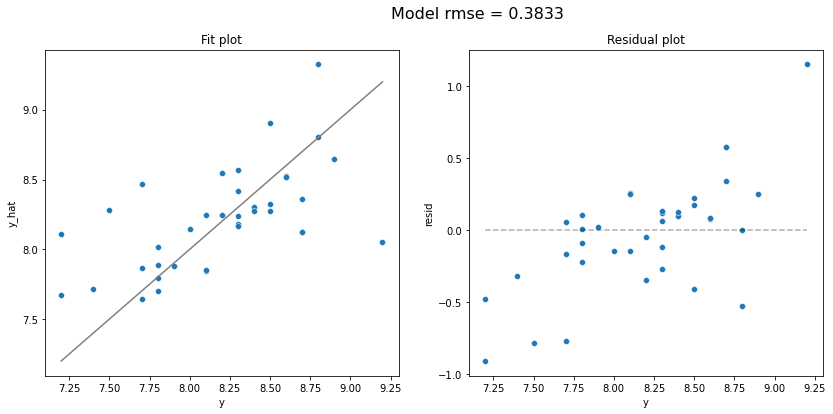

,Test RMSE,Train RMSE
Fold,,
0,0.55,0.34
1,0.45,0.34
2,0.38,0.35
3,0.52,0.33
4,0.44,0.34
5,0.49,0.33
6,0.57,0.34
7,0.38,0.35
8,0.63,0.32


In [ ]:
# perform ridge regression
ridge = make_pipeline(
    StandardScaler(),
    Ridge(alpha=10)
)

model = ridge.fit(X_train, y_train)

model_fit(model, X_test, y_test, plot=True)
scores = cross_validate(ridge, X, y, cv=10, scoring = 'neg_root_mean_squared_error', return_train_score=True)
tidy_scores(scores)

On the initial fit to our data we used a value of 10 for $\alpha$, however later on we look for the best possible choice. The results were promising, with a RMSE of 0.3833 on the test data. After cross-validation testing, we found the mean RMSE across each of the folds to be 0.48. This may not seem to be much, if any, improvement on the linear regression model, but don't forget that we are yet to tune to model to the optimal value of $\alpha$.

Let's take a quick look at the coefficients of the model:

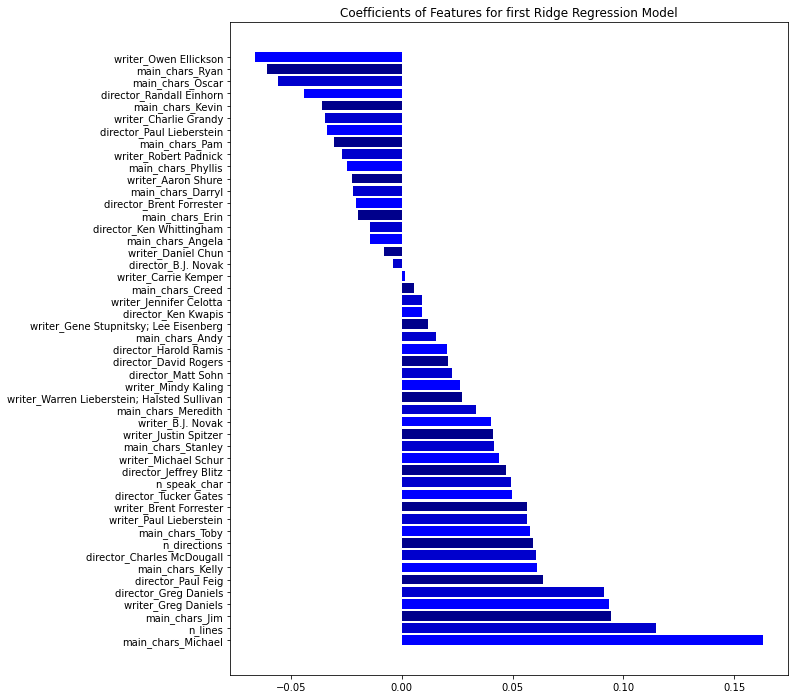

In [ ]:
beta = get_coefs(model)
beta_df = pd.DataFrame(np.column_stack((X.columns, beta[1:])))
beta_df.columns = ['Feature','Beta']
beta_df = beta_df.sort_values(by=['Beta'], axis = 0 , ascending=False)

plt.figure(figsize=(10,12))
c = ['blue', 'mediumblue', 'darkblue']
plt.barh(beta_df['Feature'],beta_df['Beta'], color=c)
plt.title('Coefficients of Features for first Ridge Regression Model')
plt.show()

## Tuning Ridge Regression

We would like to find the best value of the parameter $α$ for our model. In the code below, search over values up to 200 using the `GridSearchCV` function, which also employs 10-fold cross validation.

In [ ]:
# searching for the best alpha
alphas = np.linspace(1,200, num=200)
gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Ridge()
    ),
    param_grid={'ridge__alpha': alphas},
    cv=KFold(10, shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error"
).fit(X_train, y_train)

The best value of $α$ for our model is found to be 189. We want to find out if this process has been worth the extra time and computation, so we will perform a 10-folds cross-validation on the model using the best choice of $\alpha$.

{'ridge__alpha': 189.0}


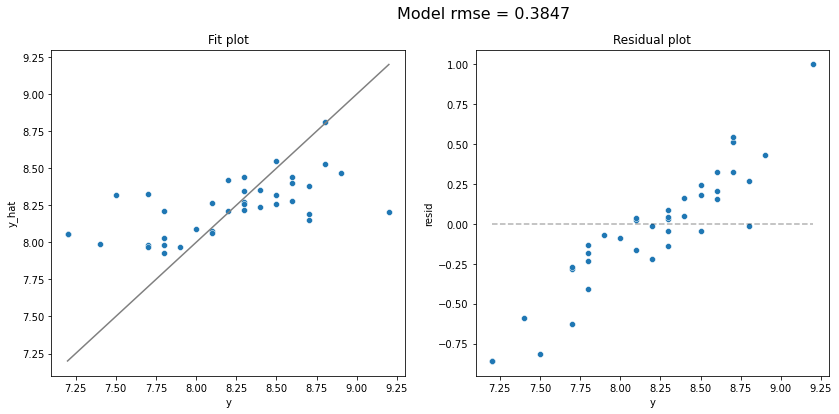

,Test RMSE,Train RMSE
Fold,,
0,0.52,0.38
1,0.44,0.39
2,0.47,0.39
3,0.44,0.38
4,0.39,0.39
5,0.43,0.38
6,0.53,0.38
7,0.33,0.40
8,0.56,0.37


In [ ]:
print(gs.best_params_) # best alpha
model_fit(gs.best_estimator_, X_test, y_test, plot=True)

scores = cross_validate(gs.best_estimator_,X, y, cv=10, scoring = 'neg_root_mean_squared_error', return_train_score=True)
tidy_scores(scores)

As you can see above, the mean RMSE across the folds was 0.45, which is a significant improvement on our initial model.

## 4. Discussion & Conclusions


We have chosen features based on an exploration of the data. Our approach is then to discover a relationship between these variables and the output we would like to predict - in this case `imdb_rating`. To establish this relationship we tried a number of methods, ending up on a model which assumes a linear relationship between each of the predicting variables and the outcome, and penalises the effect on the output of any variables which have a disproportionately large effect. We have generated this model on a smaller subset of the data and validated it's effectiveness on the remaining data. To ensure that the results are reliable, we repeat this process for a number of different subsets of the data.

This model has been based on specific features as discussed above, and this should be taken account when considering making predictions using this model. For example, we opted not to use the `air_date` feature as a predictor of the output, so if you wanted make predictions of the IMDb rating of an episode aired during a certain time of year, this model would not be suitable. The model emphasizes the effect of certain features of the data, and deems other features relatively insignificant on the influence of the output variable. However, this does not mean these features should be disregarded when making a reunion episode.

While it is important to recognise the effect of prominent characters on the output, this model fails to take into account the added effect that a wider range of characters bring in terms of group dynamics. Just because our model says a character has no influence on the IMDb rating of an episode, their effect may be more subtle, and hence they should not necessarily be excluded from a reunion episode.

## Predicting IMDB rating with the best performing characters



As our suggestion to NBC universal in making a reunion episode, we hiring the following people, which is based on the value of their coeffcients as seen above.

Since Dwight is in every episode, it is not possible to say for sure if he has a positive effect on the rating of the show. However, we would not want to ruin his streak. So we suggest putting him in, simply because there is no apparent reason not to.

We decided to recommend hiriing all the actors with a positive coefficient. This is becaue n_speak_char does not have a negative effect.

From the graph above, it is obvious that Michael has the highest influence on the rating. The director with the highest rating is Greg Daniels, so he should be hired to direct the reunion episode. Paul Lieberstein would be our recommendation for writer. The other actors in the order of their coefficient values are:
Jim, Kelly, Stanley, Meredith, Andy, Toby

After the cast and crew are fixed, we looked up the mean values for n_lines and n_speak_char for the episodes written by Paul Lieberstein and average n_directions for the episodes directed by Greg Daniels. These values would be the best estimation of how the reunion episode would also be written/directed, given their track record.

Adding these values, the predictive dataframe would look like:

In [ ]:
#creating a dataframe with only the necessary features
recommendations = pd.DataFrame({"main_chars_Michael":1,"n_directions":d.loc[d['director_Greg Daniels']==1].n_directions.mean(),"director_Greg Daniels":1,"main_chars_Jim":1,"writer_Paul Lieberstein":1,"main_chars_Kelly":1,
                                "n_lines":d.loc[d['writer_Paul Lieberstein']==1].n_lines.mean(),
                                "main_chars_Stanley":1,"n_speak_char":d.loc[d['writer_Paul Lieberstein']==1].n_speak_char.mean(),"main_chars_Meredith":1,"main_chars_Andy":1,"main_chars_Toby":1},index=[0])
#Putting it in the dataset and recovering to set the other features to 0
d=d.append(recommendations)
recommendations = d.fillna(0).drop('imdb_rating',axis=1).iloc[-1:]
predictions = gs.best_estimator_.predict(recommendations)
print("Prediction:",predictions)

Prediction: [8.72289597]
